In [1]:
# 1) Configurações iniciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
# 2) Carregando o dataset

df = pd.read_excel("data/Online_Retail.xlsx")

Dimensão original das linhas e colunas: (541909, 8)


In [12]:
# 3) Estatísticas descritivas gerais
print('Dimensão original das linhas e colunas:', df.shape)
print("\n------------------------------------")
display(df.head())
print('\n Resumo estatístico (numérico):')
print("\n------------------------------------")
display(df.describe(include=[np.number]))
print("\n------------------------------------")
print('\n Resumo (todas as colunas):')
print("\n------------------------------------")
display(df.describe(include='all'))
print("\n------------------------------------")

Dimensão original das linhas e colunas: (541909, 8)

------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



 Resumo estatístico (numérico):

------------------------------------


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



------------------------------------

 Resumo (todas as colunas):

------------------------------------


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN



------------------------------------


In [ ]:
# 4) Limpeza

# Mudando o nome das colunas
df.rename(columns={'InvoiceNo': 'cd_fatura'}, inplace=True)
df.rename(columns={'StockCode': 'cd_produto'}, inplace=True)
df.rename(columns={'Description': 'nm_produto'}, inplace=True)
df.rename(columns={'Quantity': 'qtd_vendida'}, inplace=True)
df.rename(columns={'InvoiceDate': 'dt_venda'}, inplace=True)
df.rename(columns={'UnitPrice': 'vl_unitario'}, inplace=True)
df.rename(columns={'CustomerID': 'cd_cliente'}, inplace=True)
df.rename(columns={'Country': 'nm_pais_cliente'}, inplace=True)



# Converter dt_venda para datetime
df['dt_venda'] = pd.to_datetime(df['dt_venda'])
# Criar PrecoTotal
df['PrecoTotal'] = df['qtd_vendida'] * df['vl_unitario']

# Data de corte
data_corte = pd.to_datetime('2011-10-09')

# Separarando os dados antes e depois da data de corte
df_treino = df[df['dt_venda'] <= data_corte]
df_futuro = df[df['dt_venda'] > data_corte]

print('\n Quantidade de valores faltando por coluna:')
print(df.isna().sum())


 Quantidade de valores faltando por coluna:
cd_fatura               0
cd_produto              0
nm_produto           1454
qtd_vendida             0
dt_venda                0
vl_unitario             0
cd_cliente         135080
nm_pais_cliente         0
PrecoTotal              0
dtype: int64


In [ ]:
#5) Transformação em linhas

# Remover qtd_vendida <=0 e vl_unitario <=0
df = df[(df['qtd_vendida'] > 0) & (df['vl_unitario'] > 0)]

# Remover linhas sem cd_cliente
df = df.dropna(subset=['cd_cliente'])

# Converter cd_cliente para int
df['cd_cliente'] = df['cd_cliente'].astype(int)

print('Dimensão após limpeza:', df.shape)


Dimensão após limpeza: (397884, 9)


In [ ]:
# 6) Preparando ambiente de treino
# Data de referência (um dia após o último registro antes do corte)
snapshot_date = df_treino['dt_venda'].max() + pd.Timedelta(days=1)

clientes = df_treino.groupby('cd_cliente').agg({
    'dt_venda': lambda x: (snapshot_date - x.max()).days,
    'cd_fatura': 'nunique',                               
    'PrecoTotal': 'sum',                                  
    'qtd_vendida': 'sum'                                  
}).rename(columns={
    'dt_venda': 'Recencia',
    'cd_fatura': 'Frequencia',
    'PrecoTotal': 'Monetario',
    'qtd_vendida': 'QuantidadeTotal'
})

In [ ]:
# 7) Criação do target
# Lista de clientes que compraram depois da data de corte
clientes_futuro = df_futuro['cd_cliente'].unique()

# Criando a coluna alvo
clientes['voltou'] = clientes.index.isin(clientes_futuro).astype(int)

print('Distribuição do target (0 = não voltou, 1 = voltou):')
print(clientes['voltou'].value_counts())

Distribuição do target (0 = não voltou, 1 = voltou):
voltou
0    1906
1    1840
Name: count, dtype: int64


In [ ]:
# 8) Treinamento do ML
# Separar varável de treino (X) e alvo (y)
X = clientes[['Recencia', 'Frequencia', 'Monetario', 'QuantidadeTotal']]
y = clientes['voltou']

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Normalizar os dados
scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste)

# Treinando o modelo
modelo = RandomForestClassifier(n_estimators=200, random_state=42)
modelo.fit(X_treino_scaled, y_treino)

# Predições
y_pred = modelo.predict(X_teste_scaled)

Acurácia do modelo: 65.12%

------------------------------------

Matriz de Confusão:
[[391 181]
 [211 341]]

------------------------------------

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.65      0.68      0.67       572
           1       0.65      0.62      0.64       552

    accuracy                           0.65      1124
   macro avg       0.65      0.65      0.65      1124
weighted avg       0.65      0.65      0.65      1124


------------------------------------


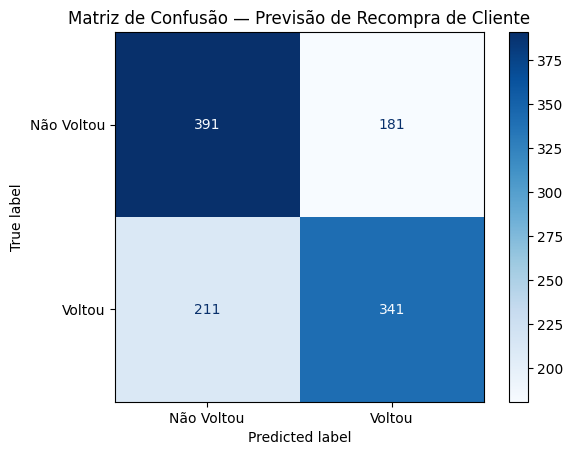

In [ ]:
# 9) Avaliando o modelo
acuracia = accuracy_score(y_teste, y_pred)
matriz_confusao = confusion_matrix(y_teste, y_pred)

print(f"Acurácia do modelo: {acuracia:.2%}")
print("\n------------------------------------")
print("\nMatriz de Confusão:")
print(matriz_confusao)
print("\n------------------------------------")
print("\nRelatório de Classificação:")
print(classification_report(y_teste, y_pred))
print("\n------------------------------------")

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=['Não Voltou', 'Voltou'])
disp.plot(cmap='Blues')
plt.title('Matriz de Confusão — Previsão de Recompra de Cliente')
plt.show()

In [ ]:
clientes['prob_voltar'] = modelo.predict_proba(scaler.transform(X))[:, 1]
display(clientes[['Recencia', 'Frequencia', 'Monetario', 'QuantidadeTotal', 'voltou', 'prob_voltar']].head())